In [23]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import json

In [29]:
df = pd.read_csv("../data/processed/engineered_features.csv", parse_dates=["DATE"])
print("Loaded data with shape:",df.shape)
df.head()

Loaded data with shape: (600, 20)


,CONS_NO,FLAG,DATE,CONSUMPTION,YEAR,MONTH,DAY,DAY_OF_WEEK,ROLL_MEAN_3,ROLL_STD_3,ROLL_MEAN_7,DIFF_1,DAILY_ENERGY,LOAD_FACTOR,MIN_MAX_RATIO,DIFF_3,DIFF_7,VOLATILITY_INDEX,OFFPEAK_3,PEAK_OFFPEAK_RATIO
0,CUST_0001,1,2014-01-01,5.68,2014,1,1,2,NaN,NaN,NaN,NaN,5.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CUST_0001,1,2014-01-02,9.22,2014,1,2,3,NaN,NaN,NaN,3.54,9.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CUST_0001,1,2014-01-03,1.92,2014,1,3,4,5.606667,3.650552,NaN,-7.30,1.92,NaN,NaN,NaN,NaN,0.651109,NaN,NaN
3,CUST_0001,1,2014-01-04,5.89,2014,1,4,5,5.676667,3.654673,NaN,3.97,5.89,NaN,NaN,0.21,NaN,0.643806,NaN,NaN
4,CUST_0001,1,2014-01-05,12.96,2014,1,5,6,6.923333,5.592069,NaN,7.07,12.96,NaN,NaN,3.74,NaN,0.807713,NaN,NaN


In [30]:

feature_cols = [
    "CONSUMPTION",
    "ROLL_MEAN_3", "ROLL_STD_3", "ROLL_MEAN_7",
    "DIFF_1", "DIFF_3", "DIFF_7",
    "DAILY_ENERGY", "LOAD_FACTOR", "MIN_MAX_RATIO",
    "VOLATILITY_INDEX",
    "OFFPEAK_3", "PEAK_OFFPEAK_RATIO"
]

df = df.dropna(subset=feature_cols)
print("After droppping NA, data shape:",df.shape)

After droppping NA, data shape: (460, 20)


In [31]:
def run_iforest(config, df):
    model = IsolationForest(
        n_estimators=config["n_estimators"],
        contamination=config["contamination"],
        max_samples=config["max_samples"],
        random_state=42
    )

    feats = df.drop(columns=["CONS_NO", "FLAG", "DATE"])
    model.fit(feats)

    scores = model.decision_function(feats)
    labels = model.predict(feats)

    return {
        "scores":scores,
        "labels":labels,
        "config":config
    }

In [33]:
configs = [
    {"n_estimators": 100, "contamination": 0.03, "max_samples": 256},
    {"n_estimators": 200, "contamination": 0.05, "max_samples": 512},
    {"n_estimators": 300, "contamination": 0.10, "max_samples": 256},
    {"n_estimators": 150, "contamination": 0.07, "max_samples": "auto"},
    {"n_estimators": 500, "contamination": 0.03, "max_samples":256}
]

configs

[{'n_estimators': 100, 'contamination': 0.03, 'max_samples': 256},
 {'n_estimators': 200, 'contamination': 0.05, 'max_samples': 512},
 {'n_estimators': 300, 'contamination': 0.1, 'max_samples': 256},
 {'n_estimators': 150, 'contamination': 0.07, 'max_samples': 'auto'},
 {'n_estimators': 500, 'contamination': 0.03, 'max_samples': 256}]

In [34]:
results = []
X = df[feature_cols]

for i, cfg in enumerate(configs, start=1):

    model = IsolationForest(
        n_estimators=cfg["n_estimators"],
        contamination=cfg["contamination"],
        max_samples=cfg["max_samples"],
        random_state=42,
        n_jobs=-1
    )

    model.fit(X)

    scores = model.decision_function(X)
    labels = model.predict(X)

    anomalies = np.sum(labels == -1)
    avg_score = np.mean(scores)

    results.append({
        "Config": i,
        "Params": cfg,
        "Anomalies": anomalies,
        "AvgScore": avg_score
    })

results_df = pd.DataFrame(results)
results_df


C:\Users\Deekshita\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_iforest.py:336: UserWarning: max_samples (512) is greater than the total number of samples (460). max_samples will be set to n_samples for estimation.
  warn(


,Config,Params,Anomalies,AvgScore
0,1,"{'n_estimators': 100, 'contamination': 0.03, '...",14,0.089585
1,2,"{'n_estimators': 200, 'contamination': 0.05, '...",23,0.068845
2,3,"{'n_estimators': 300, 'contamination': 0.1, 'm...",46,0.042542
3,4,"{'n_estimators': 150, 'contamination': 0.07, '...",33,0.058750
4,5,"{'n_estimators': 500, 'contamination': 0.03, '...",14,0.090250


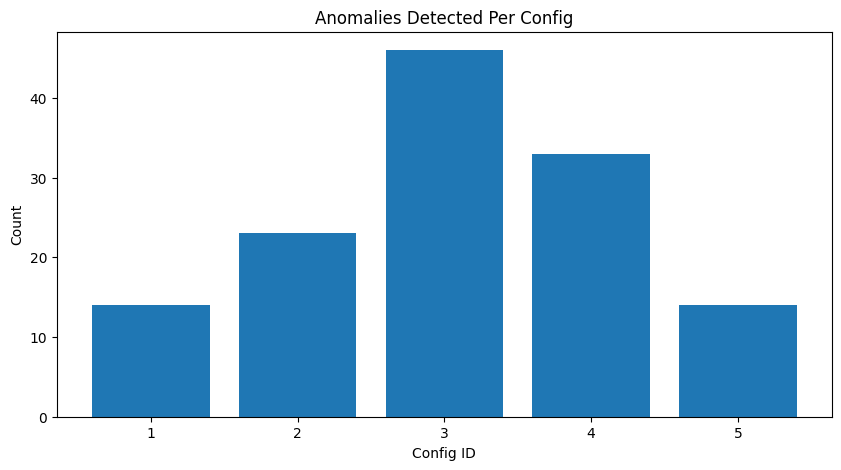

In [35]:
plt.figure(figsize=(10,5))
plt.bar(results_df["Config"], results_df["Anomalies"])
plt.title("Anomalies Detected Per Config")
plt.xlabel("Config ID")
plt.ylabel("Count")
plt.show()

In [36]:
# Choose config with moderate anomalies AND good scores:
best_idx = results_df["AvgScore"].idxmax()
best = results_df.iloc[best_idx]

best

Config                                                       5
Params       {'n_estimators': 500, 'contamination': 0.03, '...
Anomalies                                                   14
AvgScore                                               0.09025
Name: 4, dtype: object

In [37]:
final_params = best["Params"]
final_params

{'n_estimators': 500, 'contamination': 0.03, 'max_samples': 256}

In [38]:
final_model = IsolationForest(
    n_estimators=final_params["n_estimators"],
    contamination=final_params["contamination"],
    max_samples=final_params["max_samples"],
    random_state=42,
    n_jobs=-1
)

final_model.fit(X)

df["IFOREST_SCORE"] = final_model.decision_function(X)
df["IFOREST_LABEL"] = final_model.predict(X)
df["IFOREST_ANOMALY"] = (df["IFOREST_LABEL"] == -1).astype(int)

df.head()

,CONS_NO,FLAG,DATE,CONSUMPTION,YEAR,MONTH,DAY,DAY_OF_WEEK,ROLL_MEAN_3,ROLL_STD_3,...,LOAD_FACTOR,MIN_MAX_RATIO,DIFF_3,DIFF_7,VOLATILITY_INDEX,OFFPEAK_3,PEAK_OFFPEAK_RATIO,IFOREST_SCORE,IFOREST_LABEL,IFOREST_ANOMALY
7,CUST_0001,1,2014-01-08,14.44,2014,1,8,2,9.046667,7.431314,...,0.565196,0.039474,1.48,8.76,0.821442,6.923333,1.306692,0.090285,1,0
8,CUST_0001,1,2014-01-09,5.58,2014,1,9,3,10.716667,4.595980,...,0.529185,0.039474,5.01,-3.64,0.428863,6.473333,1.655510,0.110208,1,0
9,CUST_0001,1,2014-01-10,5.18,2014,1,10,4,8.400000,5.234616,...,0.561436,0.039474,-6.95,3.26,0.623169,8.553333,0.982073,0.135077,1,0
10,CUST_0001,1,2014-01-11,9.67,2014,1,11,5,6.810000,2.484894,...,0.598833,0.039474,-4.77,3.78,0.364889,9.046667,0.752763,0.135415,1,0
11,CUST_0001,1,2014-01-12,9.90,2014,1,12,6,8.250000,2.661184,...,0.568560,0.039474,4.32,-3.06,0.322568,10.716667,0.769829,0.137564,1,0


In [39]:
output_path = "../data/processed/isolation_forest_tuned_results.csv"
df.to_csv(output_path, index=False)

output_path

'../data/processed/isolation_forest_tuned_results.csv'

In [40]:
with open("../models/final_isolation_forest_params.json", "w") as f:
    json.dump(final_params, f, indent=4)

"Saved!"

'Saved!'